# svm forestfires data


In [1]:
#Q1] classify the Size_Categorie using SVM:
#month	month of the year: 'jan' to 'dec'
#day	day of the week: 'mon' to 'sun'
#FFMC	FFMC index from the FWI system: 18.7 to 96.20
#DMC	DMC index from the FWI system: 1.1 to 291.3
#DC	DC index from the FWI system: 7.9 to 860.6
#ISI	ISI index from the FWI system: 0.0 to 56.10
#temp	temperature in Celsius degrees: 2.2 to 33.30
#RH	relative humidity in %: 15.0 to 100
#wind	wind speed in km/h: 0.40 to 9.40
#rain	outside rain in mm/m2 : 0.0 to 6.4
#Size_Categorie 	the burned area of the forest ( Small , Large)


In [46]:
pip install mlxtend  


     ---------------------------------------- 1.4/1.4 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import scipy.stats as stat
from collections import Counter
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold , GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, classification_report as report,\
roc_curve, roc_auc_score , recall_score , precision_score, f1_score
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')


In [20]:
df1=pd.read_csv("C:\\Users\\hp\\Desktop\\All assignments\\svm assignment\\forestfires (1).csv")
df1.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [21]:
df1.shape

(517, 31)

In [22]:
df1[df1.columns[0:11]].describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


In [23]:
df1[df1.columns[0:11]].isnull().sum()


month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [25]:
corr = df1[df1.columns[0:11]].corr()

<Axes: >

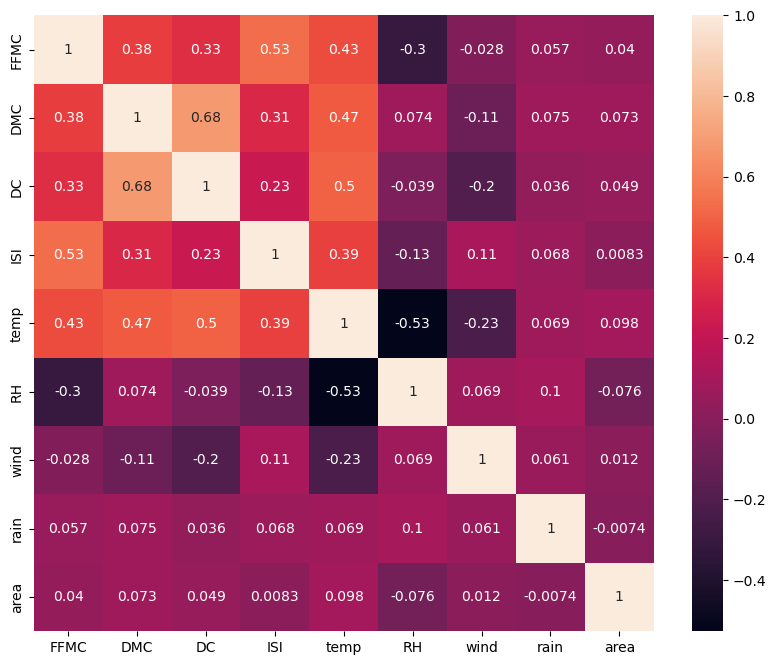

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)


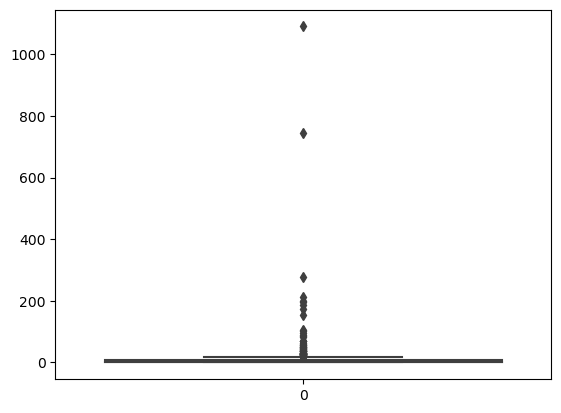

In [28]:
ax = sns.boxplot(df1['area'])


Skew: 12.846933533934868
Kurtosis: 194.1407210942299


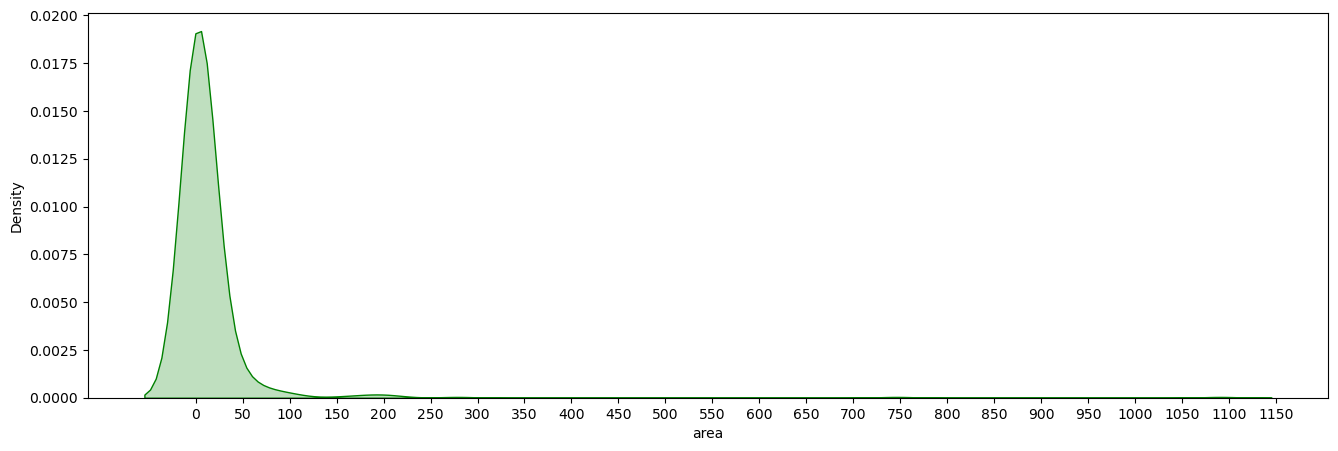

In [29]:
plt.rcParams["figure.figsize"] = 9,5
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['area'].skew()))
print("Kurtosis: {}".format(df1['area'].kurtosis()))
ax = sns.kdeplot(df1['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()


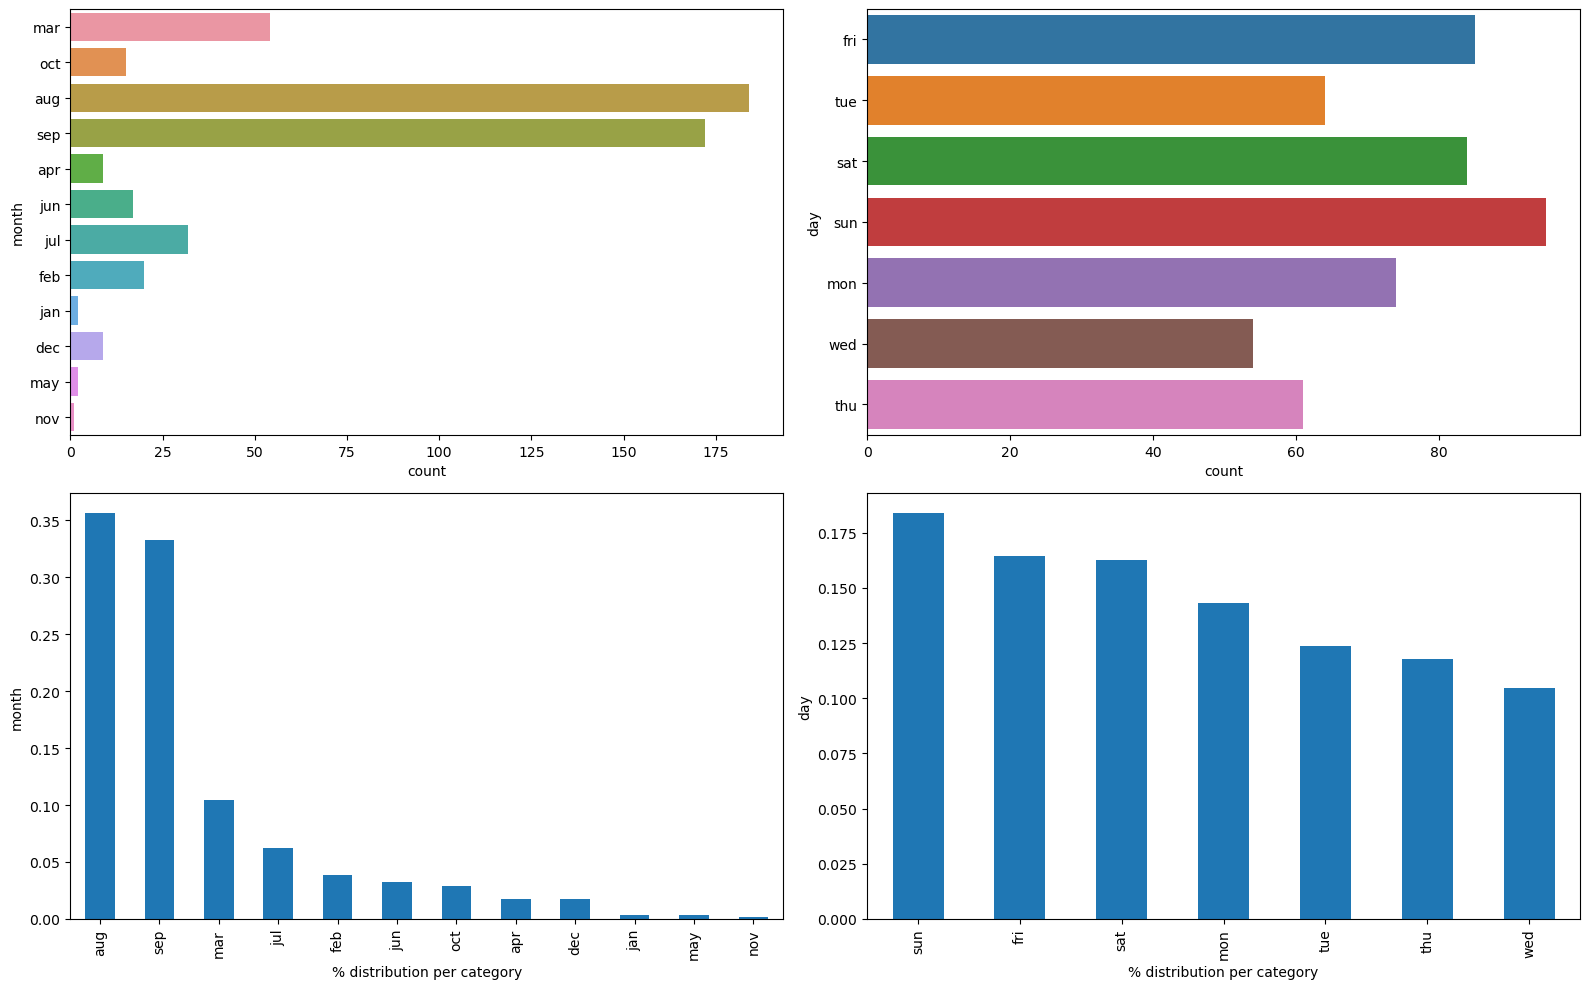

In [30]:
#the data has highly skewed and has large kurtosis value
dfa = df1[df1.columns[0:10]]
month_colum = dfa.select_dtypes(include='object').columns.tolist()
plt.figure(figsize=(16,10))
for i,col in enumerate(month_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  


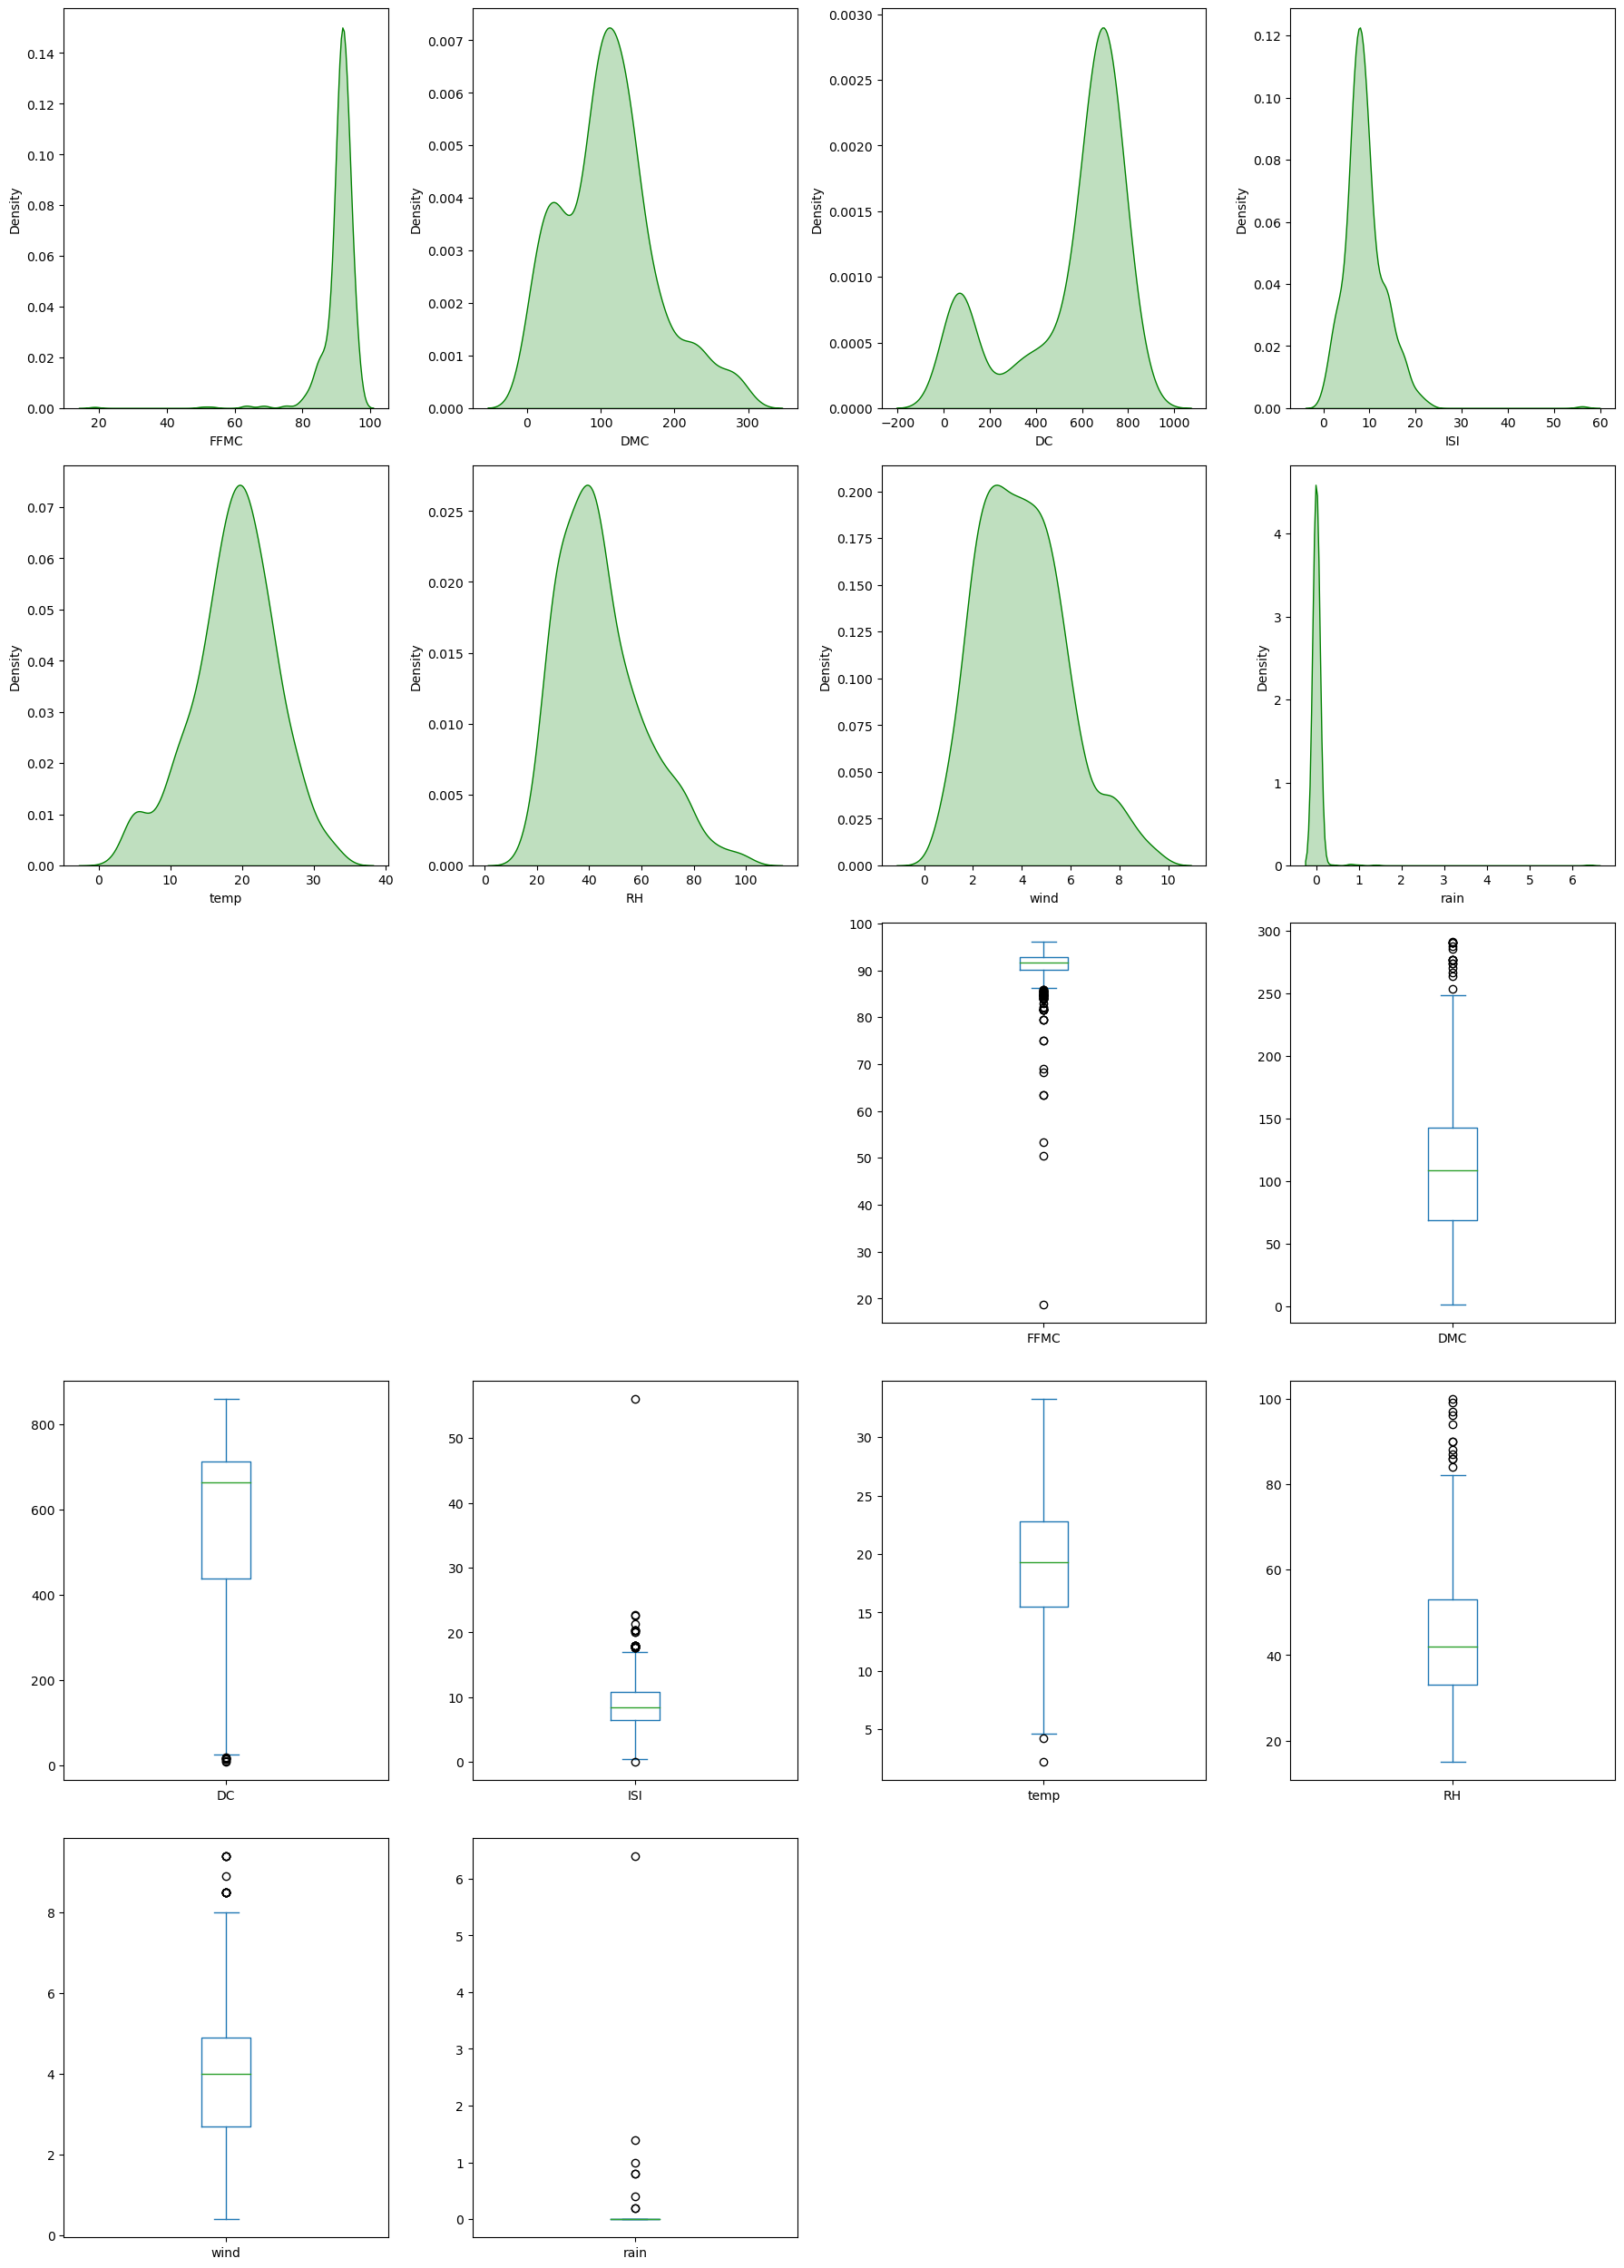

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [31]:
#majority of the fire accors inmonth of aug and sep
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])


In [32]:
#svm
X = df1.iloc[:,2:30]
y = df1.iloc[:,30]
mapping = {'small': 1, 'large': 2}
y = y.replace(mapping)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y)


In [36]:
#linear
model_linear = SVC(kernel = "linear")
model_linear.fit(x_train,y_train)
pred_test_linear = model_linear.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_linear))


Accuracy: 0.9711538461538461


In [37]:
#ploy
model_poly = SVC(kernel = "poly")
model_poly.fit(x_train,y_train)
pred_test_poly = model_poly.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_poly))


Accuracy: 0.7692307692307693


In [38]:
#rbf
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(x_train,y_train)
pred_test_rbf = model_rbf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_rbf))


Accuracy: 0.7596153846153846


In [39]:
#sigmoid
model_sigmoid = SVC(kernel = "sigmoid")
model_sigmoid.fit(x_train,y_train)
pred_test_sigmoid = model_sigmoid.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_sigmoid))


Accuracy: 0.7115384615384616


In [47]:
#linear model gives the best accuracy 
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions


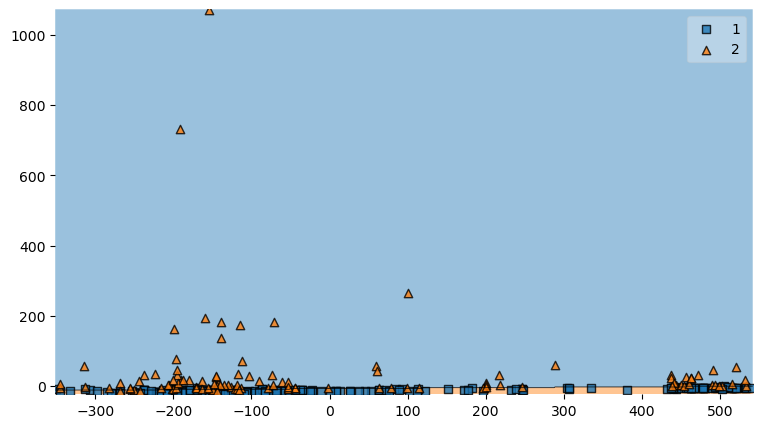

In [48]:
ytt = y_train.to_numpy()
pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train)
model_linear.fit(x_train2,ytt)
SVC(kernel='linear')
plot_decision_regions(x_train2,ytt, clf=model_linear)
plt.show()
